In [4]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns; sns.set(style='darkgrid', context='notebook')
from matplotlib import pyplot as plt
from figures.plotting import annotate_corr_grid

benchmark = 'dicarlo.MajajHong2015.IT.public-pls'
metric = 'MRR (log)'
pooling_enc = False
pooling_nshot = True
metric_columns = ['accuracy (top 1)', 'accuracy (top 5)', 'MRR']

In [5]:
data = pd.DataFrame()
for d, c in [('imagenet', 'linear'), ('imagenet', 'prototype'), 
             ('imagenet21k', 'linear'), ('imagenet21k', 'prototype')]:
    data_i = pd.read_csv(f'../results/n-shot|dataset:{d}|classifier:{c}|pooling:{pooling_nshot}.csv')
    if c == 'linear':
        data_i = data_i.drop('log likelihood', axis='columns')
        
    data_i = data_i.drop('i_repeat', axis='columns')
    data_i = data_i.groupby([c for c in data_i.columns if c not in metric_columns], as_index=False).mean()
    
    data_i = data_i.assign(classifier=c, dataset_nshot=d)
    
    data = data.append(data_i)

del data_i
    
for m in metric_columns:
    if 'log' not in m:
        data[f'{m} (log)'] = np.log(data[m])
        metric_columns.append(f'{m} (log)')
        
data = pd.merge(data, pd.read_csv(f'../results/encoding|benchmark:{benchmark}|pooling:{pooling_enc}.csv'), 
                on=['architecture', 'task', 'kind', 'source', 'layer'])

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

data.head()

,n_train,layer,architecture,task,kind,source,accuracy (top 1),accuracy (top 5),MRR,classifier,dataset_nshot,accuracy (top 1) (log),accuracy (top 5) (log),MRR (log),score,score_error
0,1,layer1.0.relu,ResNet18,Auto-Encoder,Self-Supervised,VVS,0.02792,0.12620,0.105830,linear,imagenet,-3.578412,-2.069887,-2.245918,0.225927,0.005019
1,5,layer1.0.relu,ResNet18,Auto-Encoder,Self-Supervised,VVS,0.03748,0.15500,0.123412,linear,imagenet,-3.283948,-1.864330,-2.092224,0.225927,0.005019
2,20,layer1.0.relu,ResNet18,Auto-Encoder,Self-Supervised,VVS,0.04500,0.18472,0.138450,linear,imagenet,-3.101093,-1.688914,-1.977243,0.225927,0.005019
3,50,layer1.0.relu,ResNet18,Auto-Encoder,Self-Supervised,VVS,0.04768,0.21772,0.153021,linear,imagenet,-3.043243,-1.524545,-1.877180,0.225927,0.005019
4,1,layer1.0.relu,ResNet18,Auto-Encoder,Self-Supervised,VVS,0.02612,0.11936,0.102201,prototype,imagenet,-3.645054,-2.125611,-2.280817,0.225927,0.005019


---
# Compare:
    1. In-Distribution vs. Out-of-Distribution classification
    2. Few-shot vs. Many-shot
    3. Linear classification vs. Prototype learning

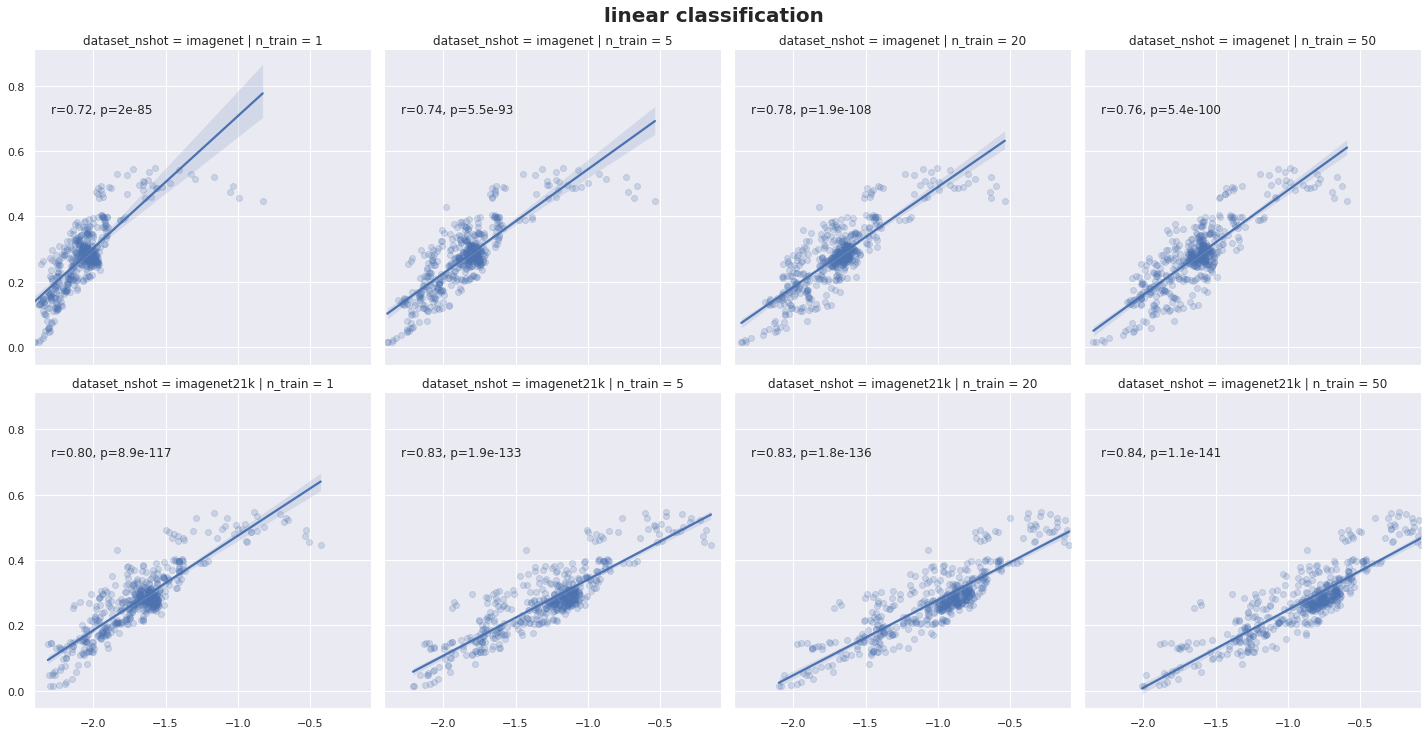

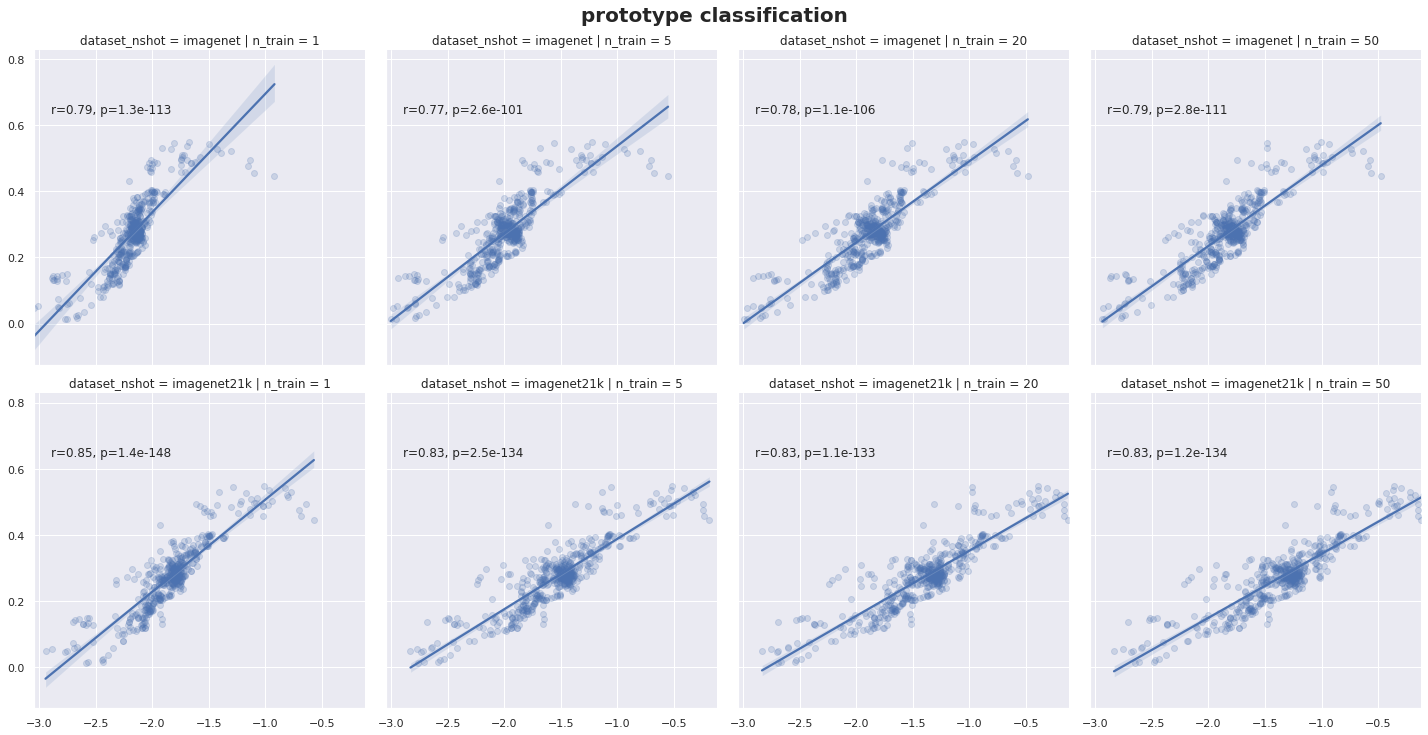

In [6]:
for c in ['linear', 'prototype']:
    g = sns.lmplot(data=data[data.classifier == c], x=metric, y='score', col='n_train', row='dataset_nshot',
                   scatter_kws={'alpha':0.2}, sharex=True, sharey=True, height=5)
    annotate_corr_grid(g, x=metric, y='score')
    fig = g.fig 
    fig.suptitle(f'{c} classification', fontsize=20, fontweight='bold', y=1.02)
    plt.show()

---
# Specific classification method and dataset 

In [7]:
classifier = 'linear'
dataset_nshot = 'imagenet21k'

data_cd = data[(data.classifier == classifier) & (data.dataset_nshot == dataset_nshot)]

## All models and layers

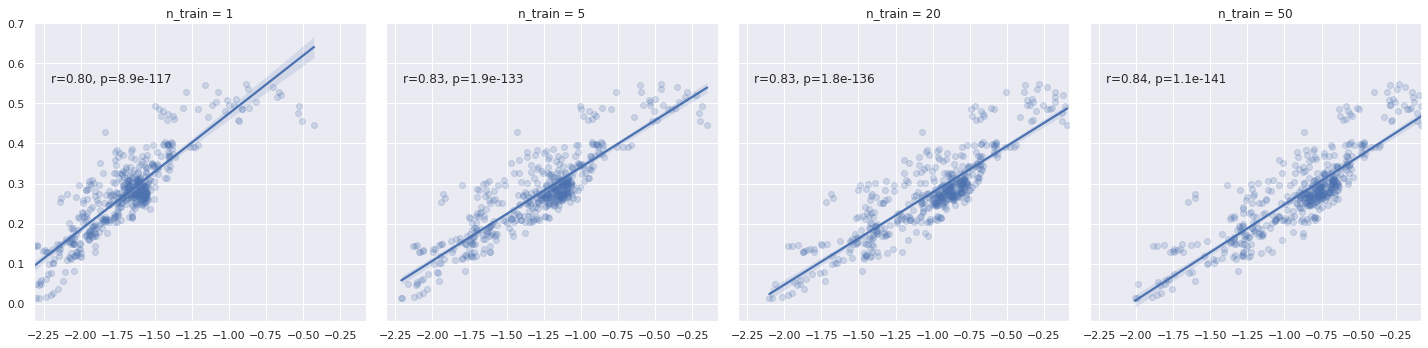

In [8]:
g = sns.lmplot(data=data_cd, x=metric, y='score', col='n_train',
               scatter_kws={'alpha':0.2}, sharex=True, sharey=True, height=5)
annotate_corr_grid(g, x=metric, y='score')
plt.show()

## ResNet 18

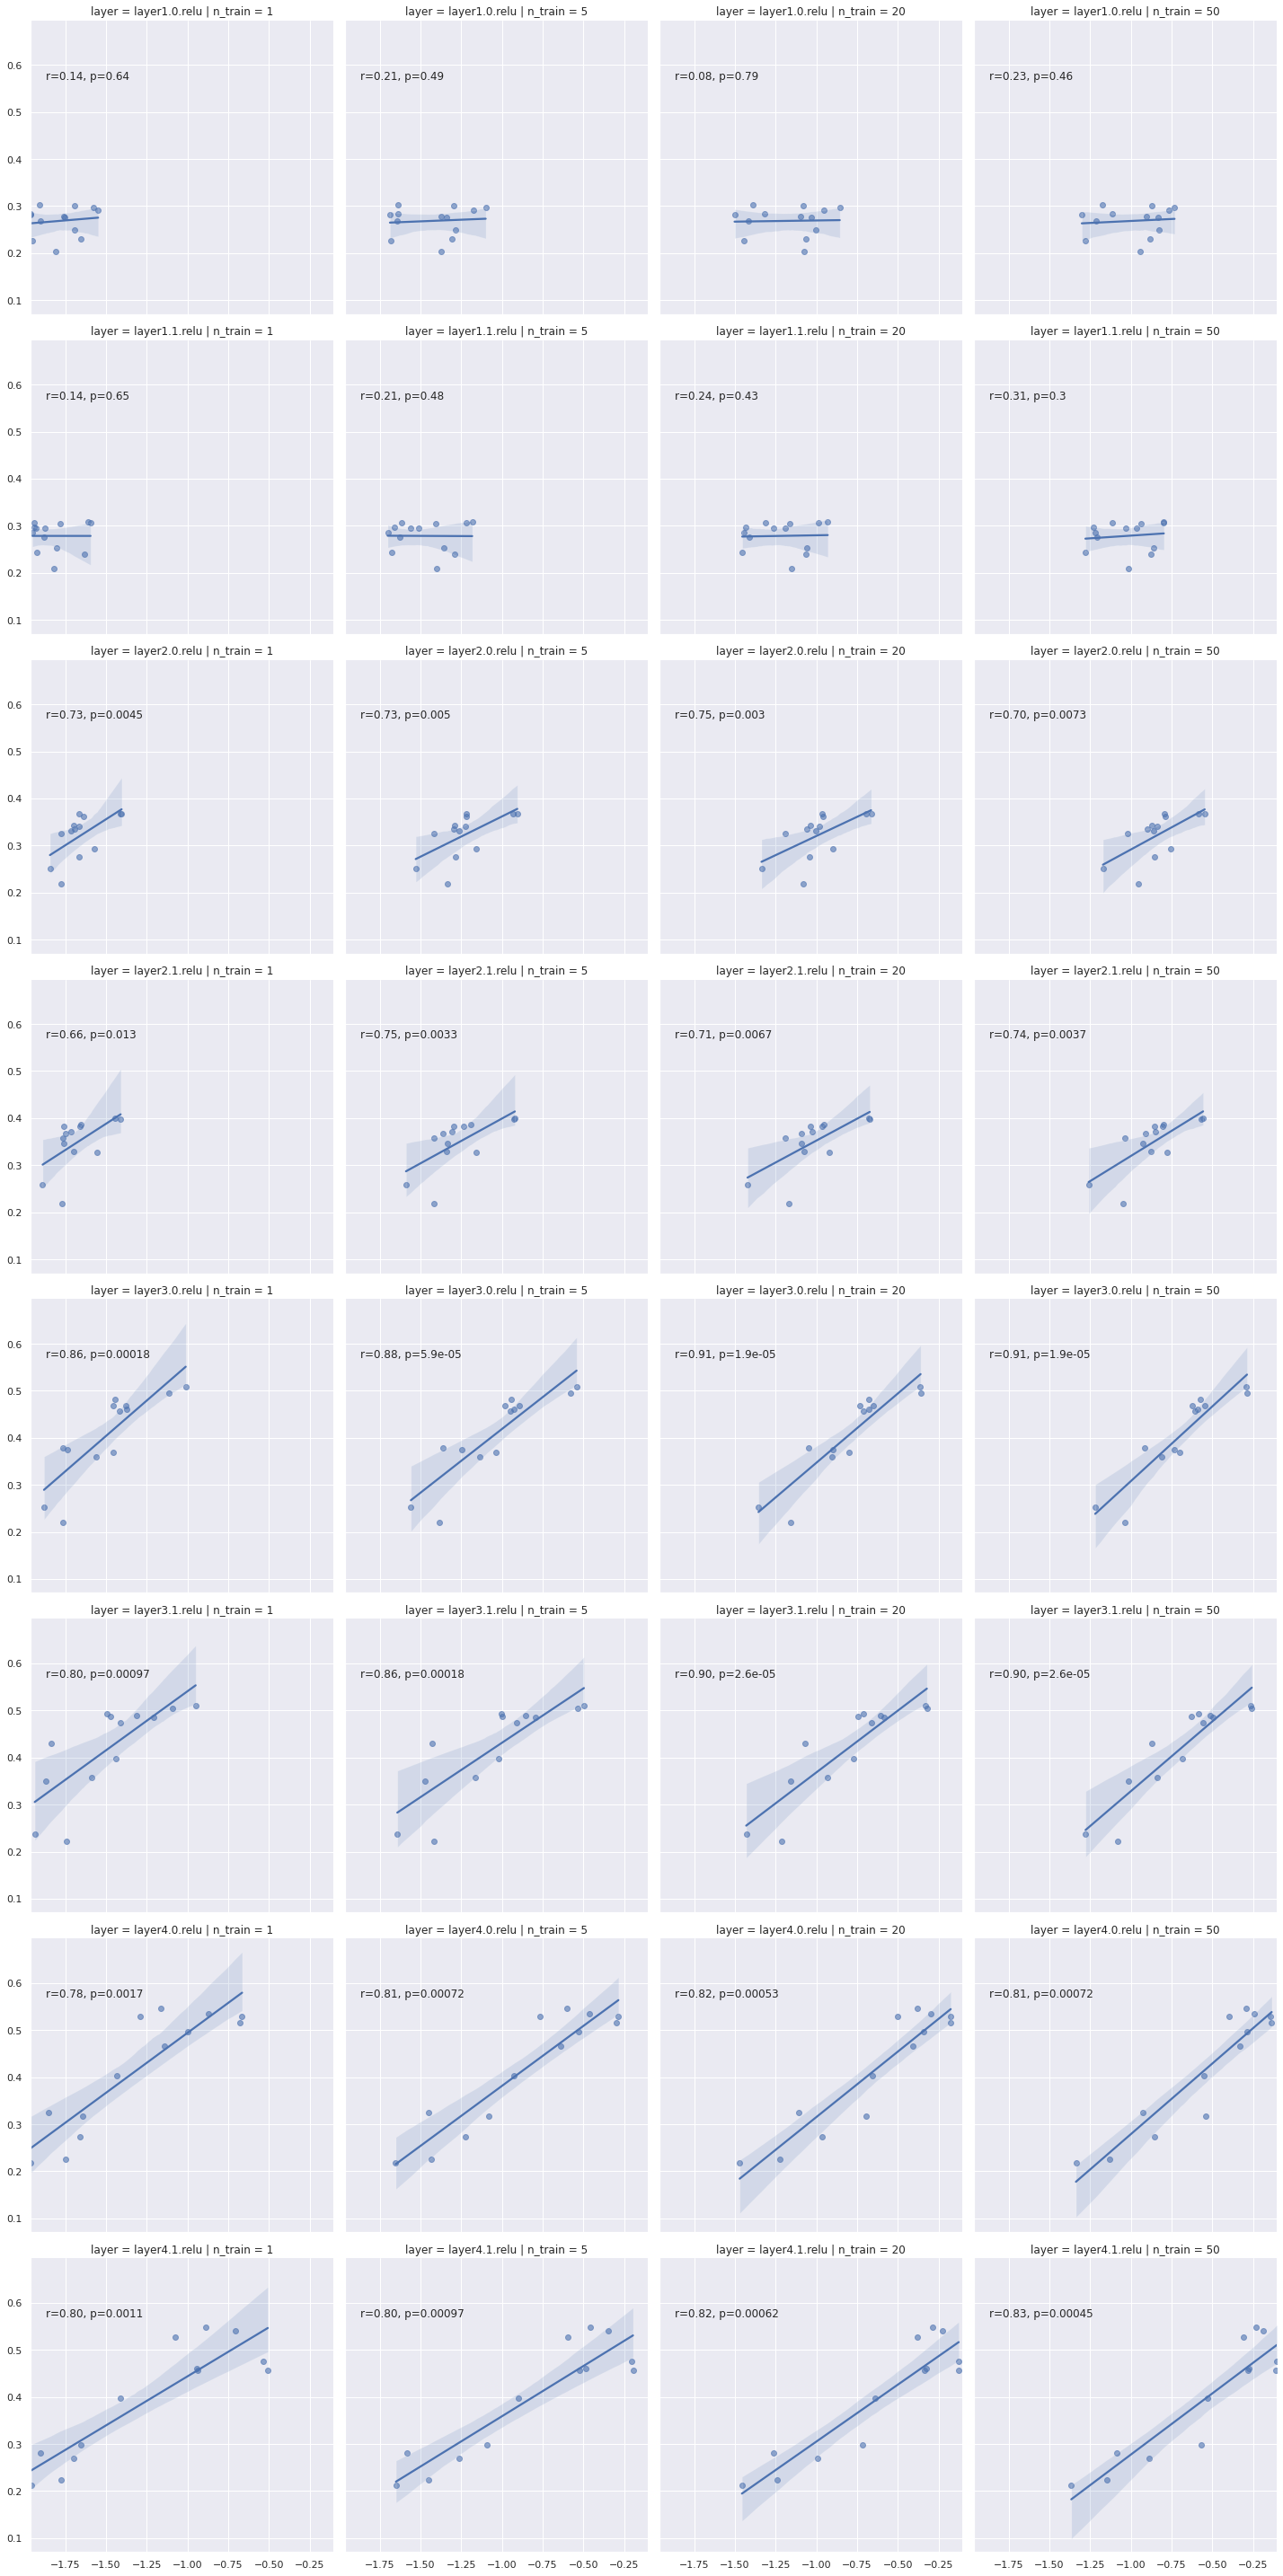

In [9]:
results = data_cd[(data_cd.architecture == 'ResNet18')]
g = sns.lmplot(data=results, x=metric, y='score', col='n_train', row='layer',
               scatter_kws={'alpha':0.6}, sharex=True, sharey=True, height=5)
annotate_corr_grid(g, x=metric, y='score')
plt.show()

## Taskonomy (ResNet 50)

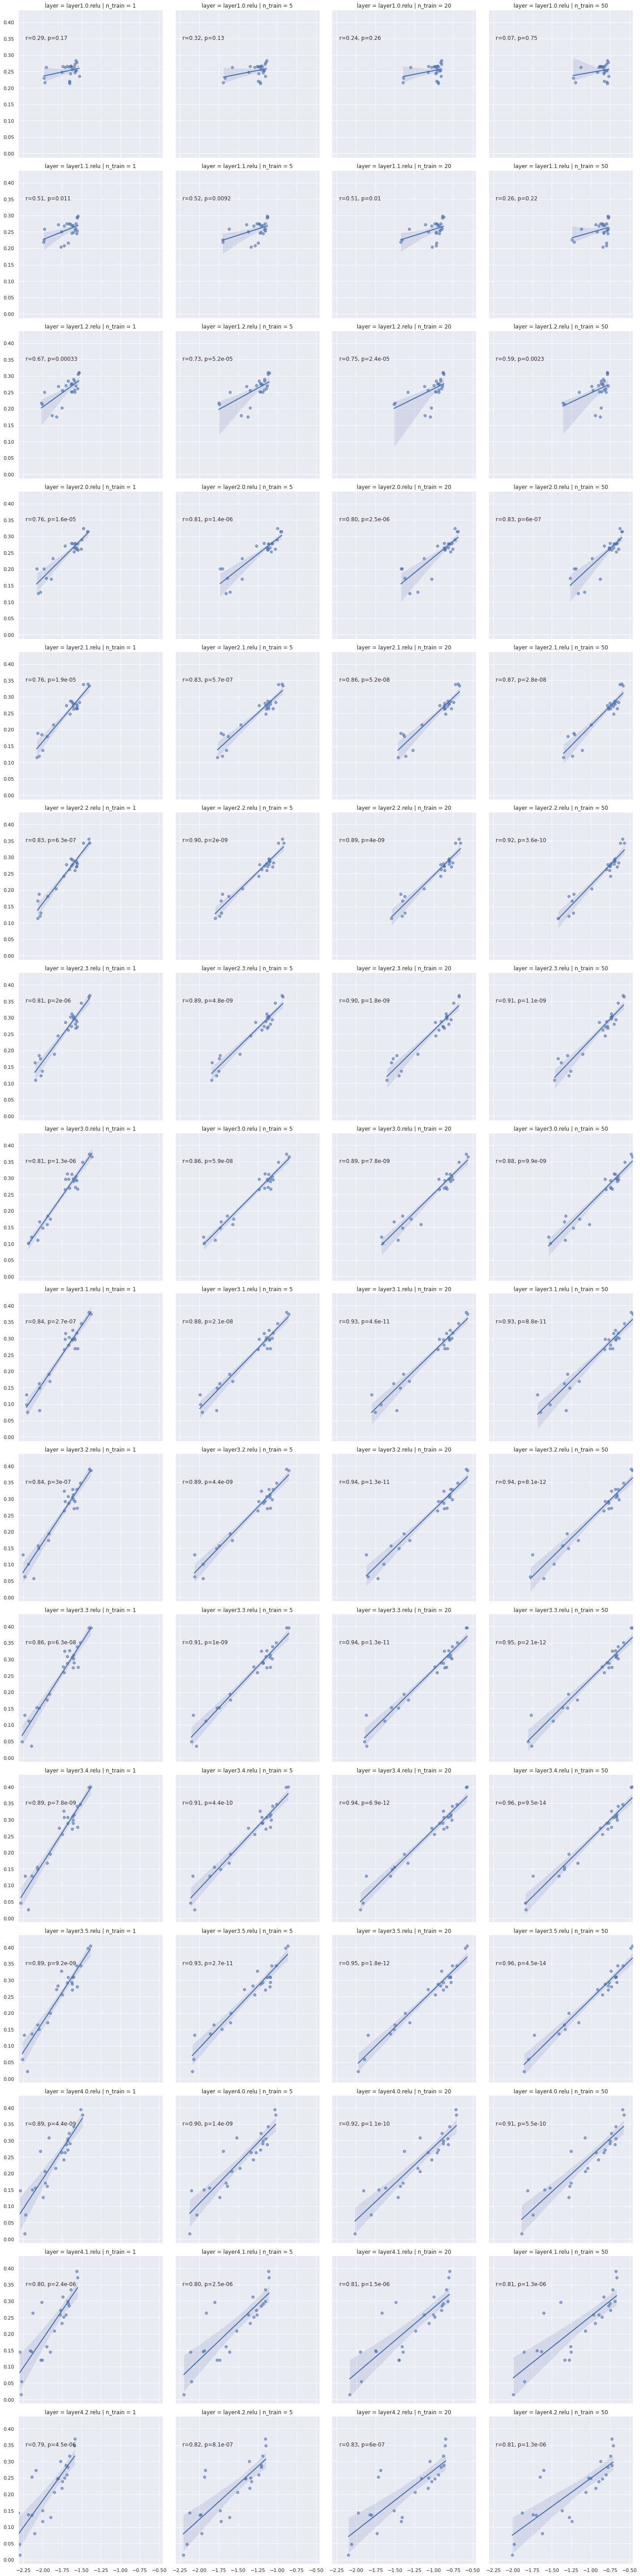

In [10]:
results = data_cd[(data_cd.source == 'Taskonomy')]
g = sns.lmplot(data=results, x=metric, y='score', col='n_train', row='layer',
               scatter_kws={'alpha':0.6}, sharex=True, sharey=True, height=5)
annotate_corr_grid(g, x=metric, y='score')
plt.show()